## This notebook uses regression.ipynb as a base and predicts with XGBoost algorithm only the IA supernovae cases and filter the outliers analysing their distribution in order to obtain a better RMSE score.
The objective of this notebook was to understand the possible errors on regression methods and improve them. 

In [1]:
%load_ext autoreload
%autoreload 2
import os 
import sys
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.modeling.functions_regression import linear_regression, normal_linear_regression, evaluate

In [3]:
pd.set_option("display.max_rows", 8)

In [5]:
df = pd.read_pickle("../../data/df.pkl")
df

,desg,desi,desr,desz,Xaxis,desg_GP,desi_GP,desr_GP,desz_GP,wavelets,...,f14,f15,f16,f17,f18,f19,f20,type,type_bool,REDSHIFT_SPEC
ID,,,,,,,,,,,,,,,,,,,,,
SN10001,"[[0.0, 2.326, 4.792], [2.0, 4.617, 2.249], [9....","[[0.031000000002677552, 8.672, 5.439], [2.1560...","[[0.01600000000325963, 8.834, 5.339], [2.13999...","[[0.06199999999807915, 6.026, 4.693], [2.18699...","[0.0, 1.1313535353535435, 2.262707070707087, 3...","([0.0, 0.818888888888886, 1.637777777777772, 2...","([0.031000000002677552, 1.141676767679467, 2.2...","([0.01600000000325963, 1.076565656568908, 2.13...","([0.06199999999807915, 1.1927272727253795, 2.3...","[9.251771363349247, 8.972870155014132, 8.79160...",...,6.048710,-11.165995,23.954122,18.206973,6.125696,9.448978,-0.078004,II,False,0.59162
SN100023,"[[6.984000000004016, 5.679, 6.387], [7.9920000...","[[7.00800000000163, 4.698, 7.145], [8.02300000...","[[0.0, 16.04, 17.59], [6.992000000005646, 19.8...","[[4.121000000006461, 18.01, 3.601], [7.0230000...","[0.0, 1.3437474747475018, 2.6874949494950036, ...","([6.984000000004016, 8.256929292933277, 9.5298...","([7.00800000000163, 8.189737373738987, 9.37147...","([0.0, 0.8994242424242942, 1.7988484848485884,...","([4.121000000006461, 5.423121212127635, 6.7252...","[12.22728787505526, 11.357060718395505, 10.716...",...,33.710197,-11.581964,28.655932,19.743614,4.619543,37.266792,-16.596040,II,False,0.79264
SN10005,"[[10.027000000001863, 4.996, 8.081], [33.94500...","[[0.015000000006693881, 0.2977, 2.206], [18.94...","[[0.0, 1.033, 1.325], [13.015000000006694, 0.4...","[[0.03500000000349246, 1.826, 3.029], [48.875,...","[0.0, 1.0381919191919462, 2.0763838383838924, ...","([10.027000000001863, 10.782565656567513, 11.5...","([0.015000000006693881, 1.0530404040470573, 2....","([0.0, 1.0281717171717606, 2.056343434343521, ...","([0.03500000000349246, 1.0222929292964054, 2.0...","[2.000004411755352, 2.000003547336676, 2.00000...",...,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562,Ia,True,1.08327
SN10007,"[[0.0, 6.266, 10.48], [10.105999999999767, 17....","[[0.03200000000651926, 7.161, 9.313], [2.01600...","[[2.0, 1.24, 2.429], [10.121000000006461, 20.0...","[[0.9770000000062282, 0.6586, 5.329], [15.9930...","[0.0, 1.5136565656566285, 3.027313131313257, 4...","([0.0, 1.5132626262626456, 3.0265252525252913,...","([0.03200000000651926, 1.5451717171782005, 3.0...","([2.0, 3.49314141414145, 4.9862828282829, 6.47...","([0.9770000000062282, 2.480787878794107, 3.984...","[11.341091517194192, 8.812204685737349, 6.9798...",...,-99.877031,21.670852,24.155364,-26.622112,-27.616185,-19.981432,49.299250,Ia,True,0.82331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN99899,"[[15.004000000000815, 1.352, 3.403], [53.87900...","[[0.0, 4.81, 2.212], [29.9059999999954, 0.0751...","[[7.019999999996799, 2.434, 1.445], [15.027999...","[[0.023999999997613486, 3.478, 3.05], [9.03499...","[0.0, 0.8468686868686516, 1.6937373737373032, ...","([15.004000000000815, 15.689212121212893, 16.3...","([0.0, 0.8468686868686516, 1.6937373737373032,...","([7.019999999996799, 7.785939393936206, 8.5518...","([0.023999999997613486, 0.8200808080784021, 1....","[20.712009726735538, 19.059663100848315, 17.84...",...,-20.467690,98.233177,-82.338152,40.618768,53.697825,-2.771304,-35.327613,II,False,0.65243
SN99921,"[[0.0, 8.327, 4.797], [2.0, 9.834, 2.261], [9....","[[0.031000000002677552, 22.78, 5.454], [2.1560...","[[0.01600000000325963, 26.73, 5.361], [2.13999...","[[0.06199999999807915, 15.19, 4.7], [2.1869999...","[0.0, 1.2923333333333222, 2.5846666666666445, ...","([0.0, 1.1299292929293416, 2.2598585858586833,...","([0.031000000002677552, 1.3230202020228414, 2....","([0.01600000000325963, 1.3080606060638358, 2.6...","([0.06199999999807915, 1.2726666666647435, 2.4...","[14.025137598441496, 16.23859348218353, 17.966...",...,30.582545,-38.454611,33.695746,32.105615,-3.304444,32.695392,-16.237457,II,False,0.69650
SN99946,"[[11.961000000002969, 1.5

In [7]:
df = df.loc[df.type_bool == True]

## Regression with IA Only

In [11]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
X = df.loc[:,'f1':'f20']
y = np.array(df.REDSHIFT_SPEC)
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(X, y, 2, 5, regressor)
ans_normal = normal_linear_regression(X, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.17545478945395648 
 Validate 2:  0.16885746807831709 
 No Validation:  0.16360022542936076

 MAE Means : 
 
 Validate 19:  0.14257809051785286 
 Validate 2:  0.13651843423977214 
 No Validation:  0.13202427444201598

 R2 Means : 
 
 Validate 19:  0.4076004296513192 
 Validate 2:  0.4513759148649049 
 No Validation:  0.48416836289892606


## Regression filtering only values within mean +- std

In [12]:
filterX = X.loc[(X.f20 > X.mean()['f20'] - X.std()['f20']) & 
                (X.f20 < X.mean()['f20'] + X.std()['f20']) &
                (X.f1 > X.mean()['f1'] - X.std()['f1']) & 
                (X.f1 < X.mean()['f1'] + X.std()['f1']) &
                (X.f2 > X.mean()['f2'] - X.std()['f2']) & 
                (X.f2 < X.mean()['f2'] + X.std()['f2']) &
                (X.f3 > X.mean()['f3'] - X.std()['f3']) & 
                (X.f3 < X.mean()['f3'] + X.std()['f3']) &
                (X.f4 > X.mean()['f4'] - X.std()['f4']) & 
                (X.f4 < X.mean()['f4'] + X.std()['f4']) &
                (X.f5 > X.mean()['f5'] - X.std()['f5']) & 
                (X.f5 < X.mean()['f5'] + X.std()['f5']) &
                (X.f6 > X.mean()['f6'] - X.std()['f6']) & 
                (X.f6 < X.mean()['f6'] + X.std()['f6']) &
                (X.f7 > X.mean()['f7'] - X.std()['f7']) & 
                (X.f7 < X.mean()['f7'] + X.std()['f7']) &
                (X.f8 > X.mean()['f8'] - X.std()['f8']) & 
                (X.f8 < X.mean()['f8'] + X.std()['f8']) &
                (X.f9 > X.mean()['f9'] - X.std()['f9']) & 
                (X.f9 < X.mean()['f9'] + X.std()['f9']) &
                (X.f10 > X.mean()['f10'] - X.std()['f10']) & 
                (X.f10 < X.mean()['f10'] + X.std()['f10']) &
                (X.f10 > X.mean()['f11'] - X.std()['f11']) & 
                (X.f10 < X.mean()['f11'] + X.std()['f11']) &
                (X.f10 > X.mean()['f12'] - X.std()['f12']) & 
                (X.f10 < X.mean()['f12'] + X.std()['f12']) &
                (X.f10 > X.mean()['f13'] - X.std()['f13']) & 
                (X.f10 < X.mean()['f13'] + X.std()['f13']) &
                (X.f10 > X.mean()['f14'] - X.std()['f14']) & 
                (X.f10 < X.mean()['f14'] + X.std()['f14']) &
                (X.f10 > X.mean()['f15'] - X.std()['f15']) & 
                (X.f10 < X.mean()['f15'] + X.std()['f15']) &
                (X.f10 > X.mean()['f16'] - X.std()['f16']) & 
                (X.f10 < X.mean()['f16'] + X.std()['f16']) &
                (X.f10 > X.mean()['f17'] - X.std()['f17']) & 
                (X.f10 < X.mean()['f17'] + X.std()['f17']) &
                (X.f10 > X.mean()['f18'] - X.std()['f18']) & 
                (X.f10 < X.mean()['f18'] + X.std()['f18']) &
                (X.f10 > X.mean()['f19'] - X.std()['f19']) & 
                (X.f10 < X.mean()['f19'] + X.std()['f19'])
               ]

In [13]:
filterX

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
ID,,,,,,,,,,,,,,,,,,,,
SN10005,-750.982205,121.777397,-119.276362,-41.573979,3.954831,-64.398708,-71.890124,-138.418639,35.188458,2.706010,-42.582112,-14.480661,36.831220,-26.554909,15.768490,16.436792,17.114795,-20.292951,-24.222566,-11.295562
SN10007,-178.038442,319.327490,-47.013389,-53.382360,117.701566,169.778801,274.165099,138.259159,21.634422,-4.749400,-62.733676,40.279861,143.184298,-99.877031,21.670852,24.155364,-26.622112,-27.616185,-19.981432,49.299250
SN100361,-550.177929,76.014412,-16.752303,-68.200149,-29.121483,-93.279208,-90.336542,48.361867,0.335150,-102.117739,56.638980,-1.505250,-65.651628,102.074783,-95.727930,4.861555,-29.749073,23.442440,5.441237,12.503390
SN100471,-675.262302,356.251531,-48.622806,-0.098109,90.304005,-1.061811,153.653330,-2.921284,22.383095,-21.853715,-8.484835,14.482021,-11.912214,-40.831628,28.629443,12.801879,-0.555542,13.065768,-21.776767,9.358561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SN9881,-606.841572,12.651683,-162.232424,-54.174687,7.198894,-63.810598,-97.281996,-133.396082,32.483589,-27.601609,17.080409,-8.895458,27.893371,8.507389,16.326763,-5.314994,30.360969,-3.380777,-35.815568,12.886525
SN98918,-368.165184,174.502476,-33.795512,-17.710726,16.975462,-34.323715,37.531632,10.284584,13.434439,1.337147,22.730192,-27.173894,46.086055,-34.255294,-4.973908,11.915895,-56.738013,-27.269352,9.479893,7.803001
SN99438,-441.101977,192.724698,191.988336,-32.272491,-15.309361,15.367184,-71.078983,81.343335,-187.437409,97.762652,-2.127234,-57.415094,-33.083382,-3.768615,-34.417710,32.878026,-33.942007,34.613437,61.324861,-51.210871
SN99457,-619.160492,299.363134,62.260933,-0.956503,79.167371,21.572217,78.410327,-36.651219,-104.416129,3.694775,-98.145512,-10.782020,29.527174,-53.090074,9.078515,-15.904951,34.732244,-14.319045,-22.934565,-9.153789


In [14]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
X = filterX
y = np.array(df.REDSHIFT_SPEC[filterX.index])
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(X, y, 2, 5, regressor)
ans_normal = normal_linear_regression(X, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.1824489002349052 
 Validate 2:  0.17752727261641194 
 No Validation:  0.1733441002538127

 MAE Means : 
 
 Validate 19:  0.14975348988460468 
 Validate 2:  0.14547479668491764 
 No Validation:  0.14202024200188634

 R2 Means : 
 
 Validate 19:  -0.14071144451069506 
 Validate 2:  -0.07996045830867812 
 No Validation:  -0.03080549399549959


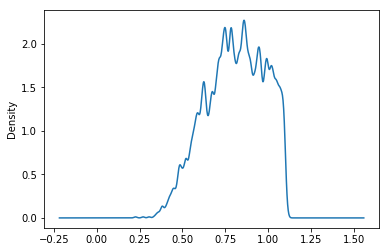

In [15]:
df.REDSHIFT_SPEC[filterX.index].plot.kde(bw_method=0.05)

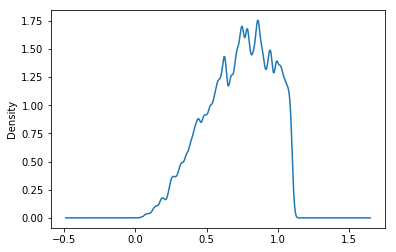

In [16]:
df.REDSHIFT_SPEC.plot.kde(bw_method=0.05)

#### Results were worse, probably the algorithm predicts well the outliers.

In [17]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f12,f13,f14,f15,f16,f17,f18,f19,f20,REDSHIFT_SPEC
count,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,...,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000,5078.000000
mean,244.003842,-8.666078,98.444379,-5.192362,-19.229632,40.764576,-11.779640,45.136799,16.924858,34.352833,...,-12.264780,-27.074712,10.088517,2.517992,1.359811,-6.024346,7.043699,-0.953759,-6.921141,0.726838
std,4482.312095,2405.422772,1697.983375,861.405975,985.757567,578.660252,569.411049,625.660899,395.231201,448.876385,...,264.716572,221.003760,255.866527,224.244640,209.898542,195.313110,166.697896,161.703537,137.933269,0.228006
min,-833.066799,-44798.662601,-20804.658610,-1253.292430,-11434.992014,-11146.024918,-15285.919749,-11549.414065,-8773.951548,-11655.770809,...,-7191.379719,-2277.657084,-6302.600915,-5588.002091,-3872.537488,-4261.668186,-4665.639997,-4263.645435,-4182.803455,0.045450
25%,-527.603543,-73.525561,-144.651673,-115.601665,-44.974676,-72.095758,-126.140933,-54.946766,-92.525895,-42.172723,...,-36.730486,-58.239822,-48.325042,-51.292690,-32.902691,-38.203445,-23.922197,-34.660869,-32.299249,0.565880
50%,-344.709863,153.684948,-30.142010,-47.917401,31.992793,-17.329944,-9.606648,24.986155,-3.884768,-1.089685,...,-8.009686,0.010161,-6.983047,-2.165538,6.660053,2.556846,6.722170,-4.002843,-3.427697,0.750685
75%,31.484133,334.589088,113.680782,5.764075,92.412573,85.659090,153.916212,96.535111,64.846265,60.891515,...,22.704001,34.149565,57.585310,35.568732,44.184737,35.807270,32.753413,32.926145,22.959640,0.908403
max,246135.667733,130701.772358,66421.630951,52745.197398,62012.632283,22327.119912,28199.279965,28074.306841,11811.804240,12351.448871,...,5135.839611,8490.251513,7033.847945,4412.920173,5777.245392,2554.981547,3207.240330,3067.694038,2532.820604,1.113680


In [18]:
filterX.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
count,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000,3958.000000
mean,-364.559794,151.372057,-38.551185,-49.522623,32.680503,3.215533,15.623087,-0.562177,-5.919012,-2.249283,-0.578875,-0.562934,-6.373393,0.312921,-9.458693,5.151486,0.142403,5.520905,-5.902200,-3.567701
std,290.839230,295.891006,183.317732,85.400112,95.456718,117.328131,160.319178,129.513676,106.152394,59.263838,70.419130,58.100882,73.259425,70.627742,65.264123,58.896314,66.051801,42.516726,45.929170,40.609110
min,-833.066799,-1775.091125,-1335.073101,-442.417778,-583.775832,-427.177168,-542.067438,-565.357919,-374.950374,-159.392818,-617.544033,-343.562988,-515.383798,-281.064860,-408.656793,-542.559488,-389.949161,-296.168669,-278.558846,-144.656551
25%,-575.919413,16.546605,-131.947274,-95.447851,-12.608623,-68.458702,-88.615284,-53.644772,-72.346204,-38.682421,-32.150889,-29.408515,-33.856601,-46.797410,-50.989570,-23.658649,-27.068779,-17.022032,-32.315355,-25.317712
50%,-415.610018,186.330942,-41.921214,-41.761846,46.746303,-25.181467,6.607497,16.421706,-2.365356,-6.397086,0.999394,-6.083778,6.133240,-12.621117,-6.540461,7.405752,4.175546,7.630512,-6.863840,-1.844181
75%,-255.699036,336.801213,61.093128,3.977395,93.425516,44.966344,154.112594,73.021203,52.587084,31.367417,36.052804,19.970548,34.180500,38.802115,27.481588,38.849528,30.667273,28.068173,21.254839,20.423574
max,1531.860609,1185.768737,759.003845,472.937626,387.015789,614.833014,439.101887,665.686130,401.471523,160.280101,489.797437,558.584002,285.453876,466.256020,633.420326,548.578893,359.859771,245.480996,206.685773,130.669173


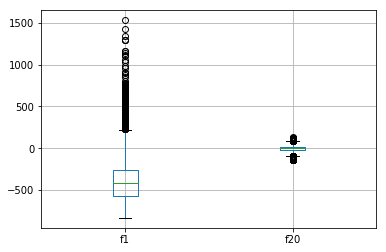

In [19]:
filterX.boxplot(column = ['f1','f20'])

## Filtering again to cut outliers.

In [20]:
filterX2 = filterX.loc[(filterX.f1 > filterX.mean()['f1'] - filterX.std()['f1']) & 
                (filterX.f1 < filterX.mean()['f1'] + filterX.std()['f1'])]

In [21]:
filterX2.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
count,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000,2988.000000
mean,-416.967155,163.631323,-39.373260,-42.873432,38.682188,-4.016386,18.495016,-2.219256,-11.416333,-4.666839,2.304752,-7.622169,0.176991,-3.350642,-17.362865,8.156131,0.714959,3.169735,-6.531022,0.437256
std,147.696096,218.248071,147.923599,69.687403,74.021465,90.073990,140.273972,111.415656,94.807091,56.298410,55.915253,43.486355,58.915470,63.665191,57.733012,49.756077,52.957482,36.190266,39.280777,38.121770
min,-655.177289,-784.253892,-756.171286,-276.737085,-237.292558,-230.175634,-416.423827,-463.370936,-304.224860,-158.739919,-276.941755,-263.665113,-245.504243,-281.064860,-223.822883,-214.270503,-389.949161,-197.944196,-155.151654,-144.220496
25%,-540.093943,20.279913,-127.972475,-87.102651,-13.347230,-65.991096,-87.694019,-40.313363,-76.302364,-41.160756,-29.277479,-31.962210,-32.263514,-48.693370,-57.245403,-21.463708,-28.325378,-18.136582,-31.569099,-21.807110
50%,-421.508521,184.486122,-41.233621,-41.543022,45.712762,-22.042500,-2.497436,23.840377,-3.900632,-6.693567,4.534509,-9.515215,6.359093,-12.971646,-12.868121,9.595378,2.232533,6.146354,-6.923648,1.851122
75%,-315.448788,334.942768,61.294091,-0.112862,95.395014,41.533433,153.504716,69.714264,50.386215,30.182880,36.000534,16.133499,35.442547,38.319656,23.649073,40.469756,29.452236,25.807768,20.160465,23.129436
max,-73.794899,675.223267,407.106141,472.937626,261.107659,401.823102,439.101887,264.101522,355.477137,160.280101,311.642476,200.391114,285.453876,209.736945,289.325310,331.408703,275.167447,131.343455,136.250403,130.669173


In [22]:
regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
X = filterX2
y = np.array(df.REDSHIFT_SPEC[filterX2.index])
ans_real_19 = linear_regression(X, y, int(len(df)/1100), 5, regressor)
ans_real_2 = linear_regression(X, y, 2, 5, regressor)
ans_normal = normal_linear_regression(X, y, 5, regressor)
evaluate(ans_real_19, ans_real_2, ans_normal)

 RMSE Means : 
 
 Validate 19:  0.1868114255764653 
 Validate 2:  0.18201309392386608 
 No Validation:  0.17731907922012474

 MAE Means : 
 
 Validate 19:  0.15462791863601388 
 Validate 2:  0.15010221210249808 
 No Validation:  0.14630100281600067

 R2 Means : 
 
 Validate 19:  -0.637906847175761 
 Validate 2:  -0.5544284170708637 
 No Validation:  -0.479053412868509


### ANS: Definitely, it's worse if we cut outliers

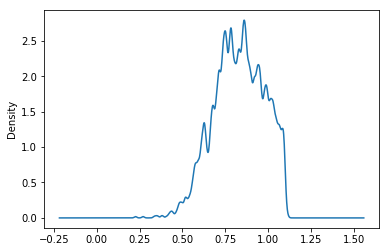

In [23]:
df.REDSHIFT_SPEC[filterX2.index].plot.kde(bw_method=0.05)

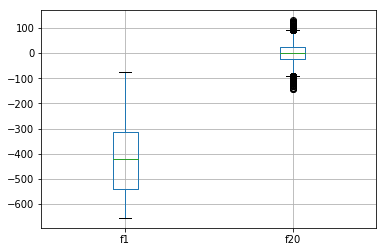

In [24]:
filterX2.boxplot(column = ['f1','f20'])